# DMRG-like training of MPS

Here we show how one can use MPS models to train via DMRG, as shown in
[[SS16']](https://arxiv.org/abs/1605.05775).

In [ ]:
%mkdir data
%mkdir models

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt

import tensorkrowch as tk

In [2]:
device = torch.device('cpu')

if torch.cuda.is_available():
    device = torch.device('cuda:0')
elif torch.backends.mps.is_available():
    device = torch.device('mps:0')
else:
    device = torch.device('cpu')

device

device(type='cuda', index=0)

## Dataset

In [3]:
# MNIST Dataset
dataset_name = 'mnist'
batch_size = 64
image_size = 15
input_size = image_size ** 2
num_classes = 10

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize(image_size, antialias=True),
                               ])

# Load data
train_dataset = datasets.MNIST(root='data/',
                               train=True,
                               transform=transform,
                               download=True)
test_dataset = datasets.MNIST(root='data/',
                              train=False,
                              transform=transform,
                              download=True)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=True)

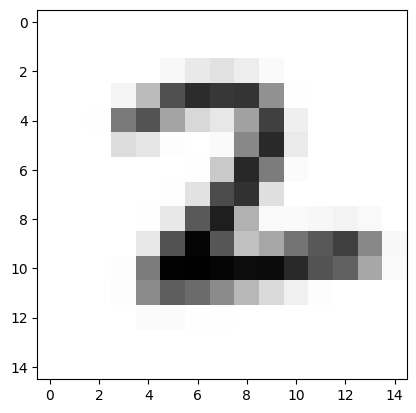

2


In [4]:
random_sample = torch.randint(low=0, high=len(train_dataset), size=(1,)).item()

plt.imshow(train_dataset[random_sample][0].squeeze(0), cmap='Greys')
plt.show()

print(train_dataset[random_sample][1])

## Define model

In [5]:
class MPS_DMRG(tk.models.MPSLayer):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.parameterize(set_param=False, override=True)
        
        self.out_node.get_axis('input').name = 'output'
        
        self.block_position = None
        self.block_length = None
    
    @property
    def block(self):
        if self.block_position is not None:
            return self.mats_env[self.block_position]
        return None
    
    def merge_block(self, block_position, block_length):
        if block_position + block_length > self.n_features:
            raise ValueError(
                f'Last position of the block ({block_position + block_length}) '
                f'exceeds the range of MPS sites ({self.n_features})')
        elif block_length < 1:
            raise ValueError(
                '`block_length` should be greater than or equal to 1')
        
        if self.block_position is not None:
            raise ValueError(
                'Cannot create block if there is already a merged block')
        
        block_nodes = self.mats_env[block_position:(block_position + block_length)]
        
        block = block_nodes[0]
        for node in block_nodes[1:]:
            block = tk.contract_between_(block, node)
        block = block.parameterize(True)
        block.name = 'block'
        
        self.block_position = block_position
        self.block_length = block_length
        self._mats_env = self._mats_env[:block_position] + [block] + \
            self._mats_env[(block_position + block_length):]
        
    def unmerge_block(self, side='right', rank=None, cum_percentage=None):
        block = self.block
        
        block_nodes = []
        for i in range(self.block_length - 1):
            node1_axes = block.axes[:2]
            node2_axes = block.axes[2:]
                
            node, block = tk.split_(block,
                                    node1_axes,
                                    node2_axes,
                                    side=side,
                                    rank=rank,
                                    cum_percentage=cum_percentage)
            block.get_axis('split').name = 'left'
            node.get_axis('split').name = 'right'
            node.name = f'mats_env_({self.block_position + i})'
            
            block_nodes.append(node)
            
        block.name = f'mats_env_({self.block_position + i + 1})'
        block_nodes.append(block)
        
        self._mats_env = self._mats_env[:self.block_position] + block_nodes + \
            self._mats_env[(self.block_position + 1):]
        
        self.block_position = None
        self.block_length = None
    
    def contract(self):
        result_mats = []
        for node in self.mats_env:
            while any(['input' in name for name in node.axes_names]):
                for axis in node.axes:
                    if 'input' in axis.name:
                        data_node = node.neighbours(axis)
                        node = node @ data_node
                        break
            result_mats.append(node)
        
        result_mats = [self.left_node] + result_mats + [self.right_node]
        
        result = result_mats[0]
        for node in result_mats[1:]:
            result @= node
        
        return result

In [7]:
# Model hyperparameters
embedding_dim = 2
output_dim = num_classes
bond_dim = 50
init_method = 'unit'
block_length = 2
cum_percentage = 0.98

In [17]:
# Initialize network
model_name = 'mps_dmrg'
mps = MPS_DMRG(n_features=input_size + 1,
               in_dim=embedding_dim,
               out_dim=num_classes,
               bond_dim=bond_dim,
               boundary='obc',
               init_method=init_method,
               device=device)

# Important to set data nodes before merging nodes
mps.set_data_nodes()

In [13]:
def embedding(x):
    x = tk.embeddings.unit(x, dim=embedding_dim)
    return x

## Train

In [18]:
# Hyperparameters
learning_rate = 1e-3
weight_decay = 1e-8
num_epochs = 100
move_block_epochs = 100

# Loss and optimizer
criterion = nn.CrossEntropyLoss()

In [19]:
# Check accuracy on training & test to see how good our model is
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            x = x.reshape(x.shape[0], -1)
            
            scores = model(embedding(x))
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        accuracy = float(num_correct) / float(num_samples) * 100
    model.train()
    return accuracy

In [20]:
# Train network
block_position = 0
direction = 1
mps.merge_block(block_position, block_length)
mps.trace(torch.zeros(1, input_size, embedding_dim, device=device))
optimizer = optim.Adam(mps.parameters(),
                       lr=learning_rate,
                       weight_decay=weight_decay)

for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device)
        targets = targets.to(device)
        
        # Get to correct shape
        data = data.reshape(data.shape[0], -1)
        
        # Forward
        scores = mps(embedding(data))
        loss = criterion(scores, targets)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient descent
        optimizer.step()
        
        if (batch_idx + 1) % move_block_epochs == 0:
            if block_position + direction + block_length > mps.n_features:
                direction *= -1
            if block_position + direction < 0:
                direction *= -1
            if block_length == mps.n_features:
                direction = 0
            
            if direction >= 0:
                mps.unmerge_block(side='left',
                                  rank=bond_dim, 
                                  cum_percentage=cum_percentage)
            else:
                mps.unmerge_block(side='right',
                                  rank=bond_dim, 
                                  cum_percentage=cum_percentage)
            
            block_position += direction
            mps.merge_block(block_position, block_length)
            mps.trace(torch.zeros(1, input_size, embedding_dim, device=device))
            optimizer = optim.Adam(mps.parameters(),
                                   lr=learning_rate,
                                   weight_decay=weight_decay)
    
    train_acc = check_accuracy(train_loader, mps)
    test_acc = check_accuracy(test_loader, mps)
    
    print(f'* Epoch {epoch + 1:<3} ({block_position=}, {direction=})=>'
          f' Train. Acc.: {train_acc:.2f},'
          f' Test Acc.: {test_acc:.2f}')

# Reset before saving the model
mps.reset()
torch.save(mps.state_dict(), f'models/{model_name}_{dataset_name}.pt')

* Epoch 1   (block_position=9, direction=1)=> Train. Acc.: 12.75, Test Acc.: 13.15
* Epoch 2   (block_position=18, direction=1)=> Train. Acc.: 12.88, Test Acc.: 13.35
* Epoch 3   (block_position=27, direction=1)=> Train. Acc.: 13.07, Test Acc.: 13.63
* Epoch 4   (block_position=36, direction=1)=> Train. Acc.: 13.25, Test Acc.: 13.20
* Epoch 5   (block_position=45, direction=1)=> Train. Acc.: 15.93, Test Acc.: 15.27
* Epoch 6   (block_position=54, direction=1)=> Train. Acc.: 17.78, Test Acc.: 16.93
* Epoch 7   (block_position=63, direction=1)=> Train. Acc.: 18.97, Test Acc.: 17.51
* Epoch 8   (block_position=72, direction=1)=> Train. Acc.: 21.57, Test Acc.: 18.85
* Epoch 9   (block_position=81, direction=1)=> Train. Acc.: 22.80, Test Acc.: 19.67
* Epoch 10  (block_position=90, direction=1)=> Train. Acc.: 24.91, Test Acc.: 21.50
* Epoch 11  (block_position=99, direction=1)=> Train. Acc.: 27.40, Test Acc.: 23.48
* Epoch 12  (block_position=108, direction=1)=> Train. Acc.: 29.46, Test Acc.

In [21]:
mps.unmerge_block(rank=bond_dim, cum_percentage=cum_percentage)

In [22]:
mps.update_bond_dim()

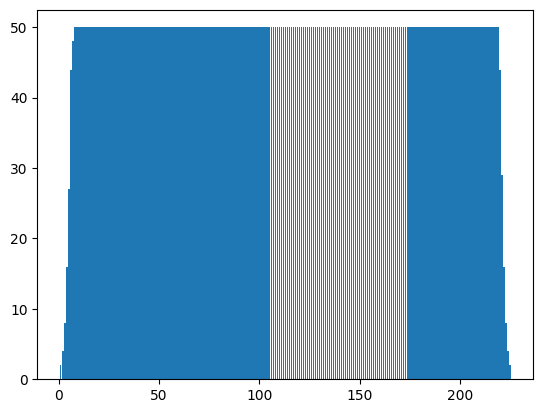

In [27]:
plt.bar(torch.arange(mps.n_features - 1) + 1, torch.tensor(mps.bond_dim))
plt.show()